In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gc

%matplotlib inline

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
stemmer = SnowballStemmer('english')

In [4]:
#functions - warning these are slow

def word_tokenize(text, how = 'lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def spelling(text):
    words = TextBlob(text).words
    return [word.correct() for word in words]

### Exploratory Data Analysis

In [6]:
#load in csv files and preview training set

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_ids = train['id']
test_ids = test['id']

del train['id']
del test['id']

train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [7]:
#preview test set

test.head()

,comment_text
0,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,::Kentuckiana is colloquial. Even though the ...
2,"Hello fellow Wikipedians,\nI have just modifie..."
3,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,== [WIKI_LINK: Talk:Celts] ==


In [8]:
#train info

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95851 entries, 0 to 95850
Data columns (total 7 columns):
comment_text     95851 non-null object
toxic            95851 non-null int64
severe_toxic     95851 non-null int64
obscene          95851 non-null int64
threat           95851 non-null int64
insult           95851 non-null int64
identity_hate    95851 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.1+ MB


In [9]:
#test info

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226998 entries, 0 to 226997
Data columns (total 1 columns):
comment_text    226997 non-null object
dtypes: object(1)
memory usage: 1.7+ MB


In [10]:
test.fillna(' ', inplace = True)

In [11]:
#how many rows of train and test

print('train = ' + str(train.shape))
print('test = ' + str(test.shape))

train = (95851, 7)
test = (226998, 1)


In [12]:
#counts

print('toxic = ' + str(train['toxic'].sum()))
print('severe toxic = ' + str(train['severe_toxic'].sum()))
print('obscene = ' + str(train['obscene'].sum()))
print('threat = ' + str(train['threat'].sum()))
print('insult = ' + str(train['insult'].sum()))
print('identity_hate = ' + str(train['identity_hate'].sum()))

toxic = 9237
severe toxic = 965
obscene = 5109
threat = 305
insult = 4765
identity_hate = 814


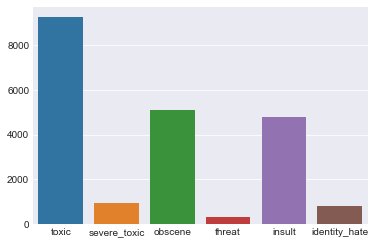

In [13]:
#distribution of toxic categories

sns.set_style('darkgrid')
sns.barplot(x = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], y = [9237, 965, 5109, 305, 4765, 814])

In [20]:
#define binary response for analysis, can see that comment can contain multiple tags

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
train.tail()

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length,toxic_boolean
95846,"""\nI have discussed it, unlike most of those w...",0,0,0,0,0,0,0,477,1
95847,"ps. Almost forgot, Paine don't reply back to t...",1,0,1,0,0,0,1,147,1
95848,Mamoun Darkazanli\nFor some reason I am unable...,0,0,0,0,0,0,0,230,1
95849,Salafi would be a better term. It is more poli...,0,0,0,0,0,0,0,295,1
95850,making wikipedia a better and more inviting pl...,0,0,0,0,0,0,0,50,1


In [15]:
#length of comment

print('average characters toxic = ' + str(np.mean(train.comment_text[train['toxic_all'] >= 1].str.len())))
print('average characters non-toxic = ' + str(np.mean(train.comment_text[train['toxic_all'] == 0].str.len())))
print('median characters toxic = ' + str(np.median(train.comment_text[train['toxic_all'] >= 1].str.len())))
print('median characters non-toxic = ' + str(np.median(train.comment_text[train['toxic_all'] == 0].str.len())))

average characters toxic = 312.2150153217569
average characters non-toxic = 404.798085079188
median characters toxic = 129.0
median characters non-toxic = 216.0


In [16]:
train['comment_length'] = train['comment_text'].str.len()
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length
0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,1,83
1,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,0,142
2,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,0,411
3,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,0,148
4,The reader here is not going by my say so for ...,0,0,0,0,0,0,0,266


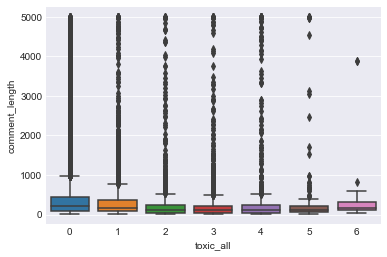

In [17]:
#boxplot x = comment category, y = length of comment text

sns.boxplot(x = train['toxic_all'], y = train['comment_length'])

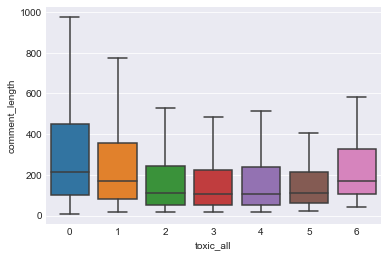

In [18]:
#exclude outliers

sns.boxplot(x = train['toxic_all'], y = train['comment_length'], showfliers = False)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


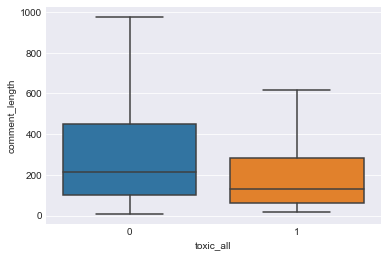

In [23]:
#boolean response boxplot

train.toxic_all[train['toxic_all'] > 0] = 1
sns.boxplot(x = train['toxic_all'], y = train['comment_length'], showfliers = False)

In [25]:
#sentiment analysis

train['sentiment'] = train['comment_text'].apply(lambda x: TextBlob(x).sentiment)
train[['sentiment_polarity', 'sentiment_subjectivity']] = train['sentiment'].apply(pd.Series)
del train['sentiment']
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all,comment_length,toxic_boolean,sentiment_polarity,sentiment_subjectivity
0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,1,83,1,0.350000,0.650000
1,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,0,142,1,0.000000,0.000000
2,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,0,411,1,-0.040625,0.771875
3,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,0,148,1,0.175000,0.625000
4,The reader here is not going by my say so for ...,0,0,0,0,0,0,0,266,1,-0.075000,0.250000


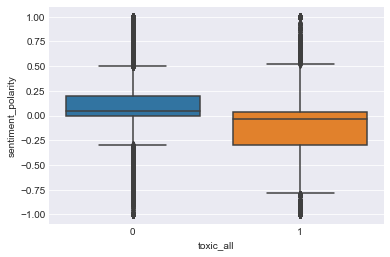

In [26]:
#sentiment boxplot

sns.boxplot(x = train['toxic_all'], y = train['sentiment_polarity'])

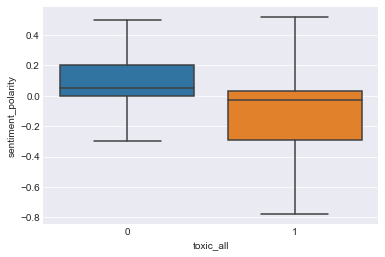

In [27]:
#without outliers, most toxic comments have negative sentiment polarity

sns.boxplot(x = train['toxic_all'], y = train['sentiment_polarity'], showfliers = False)

In [26]:
print('average polarity toxic = ' + str(np.mean(train.sentiment_polarity[train['toxic_all'] >= 1])))
print('average polarity non-toxic = ' + str(np.mean(train.sentiment_polarity[train['toxic_all'] == 0])))

average polarity toxic = -0.10908265495448481
average polarity non-toxic = 0.09483857366776806


(-0.5, 399.5, 199.5, -0.5)

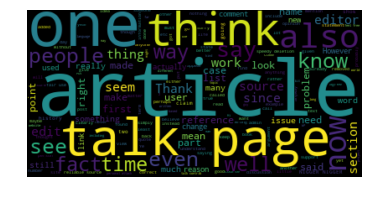

In [22]:
#generate and plot wordclouds

wordcloud = WordCloud().generate(' '.join(train['comment_text']))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

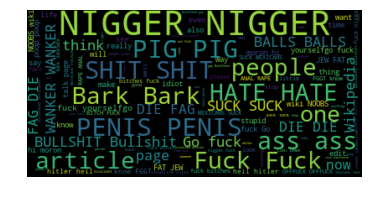

In [23]:
#toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['toxic'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

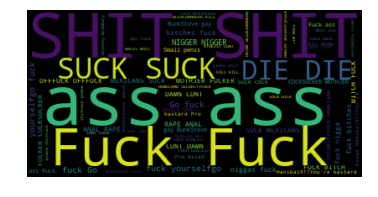

In [24]:
#severe toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['severe_toxic'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

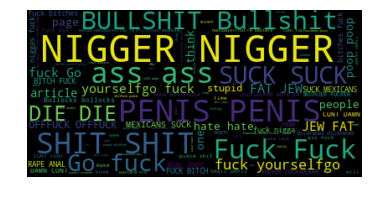

In [25]:
#obscene wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['obscene'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

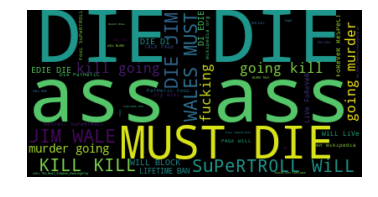

In [26]:
#threat wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['threat'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

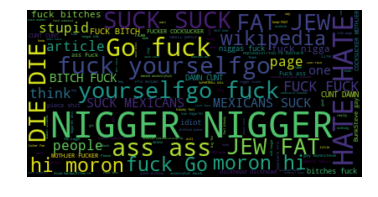

In [27]:
#insult wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['insult'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

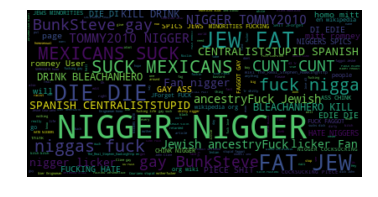

In [28]:
#identity hate wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['identity_hate'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### Data Preprocessing

In [37]:
#decode feature column, remove special characters

train['comment_text'] = train['comment_text'].str.lower() #decode and lowercase
train['comment_text'] = train['comment_text'].str.replace('"', '') #remove double quotes
train['comment_text'] = train['comment_text'].str.replace('\'', '') #remove single quotes
train['comment_text'] = train['comment_text'].str.replace(' / ', ' ') #remove slashes
train['comment_text'] = train['comment_text'].str.replace('/', ' ') #remove slashes
train['comment_text'] = train['comment_text'].str.replace('.', ' ') #remove periods
train['comment_text'] = train['comment_text'].str.replace('\n', ' ') #remove new line characters

test['comment_text'] = test['comment_text'].str.lower() #decode and lowercase
test['comment_text'] = test['comment_text'].str.replace('"', '') #remove double quotes
test['comment_text'] = test['comment_text'].str.replace('\'', '') #remove single quotes
test['comment_text'] = test['comment_text'].str.replace(' / ', ' ') #remove slashes
test['comment_text'] = test['comment_text'].str.replace('/', ' ') #remove slashes
test['comment_text'] = test['comment_text'].str.replace('.', ' ') #remove periods
test['comment_text'] = test['comment_text'].str.replace('\n', ' ') #remove new line characters

In [38]:
gc.collect()

0

In [45]:
#insantiate and fit transform tfidf vectorizer (term frequency)

vect = TfidfVectorizer(analyzer = lambda x: word_tokenize(x, how = 'stem'), strip_accents = 'unicode')

#create document term matrices

train_dtm = vect.fit_transform(train['comment_text'])
test_dtm = vect.transform(test['comment_text'])

#ensure columns match

print(train_dtm.shape)
print(test_dtm.shape)

(95851, 144233)
(226998, 144233)


In [40]:
#fit logistic regression for first response

logreg = LogisticRegression()
logreg.fit(train_dtm, train['toxic'])
toxic_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['toxic'])

#second response

logreg.fit(train_dtm, train['severe_toxic'])
severe_toxic_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['severe_toxic'])

#third response

logreg.fit(train_dtm, train['obscene'])
obscene_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['obscene'])

#fourth response

logreg.fit(train_dtm, train['threat'])
threat_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['threat'])

#fifth response

logreg.fit(train_dtm, train['insult'])
insult_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['insult'])

#sixth response

logreg.fit(train_dtm, train['identity_hate'])
identity_hate_preds = pd.DataFrame(logreg.predict_proba(test_dtm)[:,1], columns = ['identity_hate'])

In [41]:
result = pd.DataFrame(test_ids, columns = ['id'])
result['toxic'] = toxic_preds
result['severe_toxic'] = severe_toxic_preds
result['obscene'] = obscene_preds
result['threat'] = threat_preds
result['insult'] = insult_preds
result['identity_hate'] = identity_hate_preds
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.046212,0.007818,0.025825,0.002736,0.022634,0.006808
1,6102620,0.007539,0.001189,0.005119,0.000727,0.003095,0.001913
2,14563293,0.001358,0.000662,0.001781,0.000578,0.001542,0.000619
3,21086297,0.060016,0.008184,0.034697,0.002401,0.020706,0.005617
4,22982444,0.028671,0.004968,0.014332,0.002111,0.009587,0.003929


In [42]:
result.to_csv('submission.csv', index = False)

### Submission Results

1. baseline logistic regression CountVectorizer = .084
2. baseline logistic regression TfidfVectorizer = .057
3. baseline logistic regression TfidfVectorizer stemming work tokenizer = .055
4. same as above with some text cleaning = 